In [1]:
#Processes output spike trains after simulation
res_folder = '../output_sim_SP_1/' #to load results from
neuron_file = 'neuron_list1' #to load neuron data from

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spike_data = pd.read_csv(res_folder + 'spk.dat', sep=' ', header=None, names=['t', 'id'])
spike_data.head()

,t,id
0,35.333,82
1,35.333,94
2,35.333,172
3,35.333,288
4,35.333,324


In [4]:
#load neuron list
nrn_list = pd.DataFrame.from_csv('../build/' + neuron_file + '.csv', sep=' ')
idx_E = np.where(nrn_list.type=='LIF_exc')[0]
idx_I = np.where(nrn_list.type=='LIF_inh')[0]
nrn_type = np.zeros((len(nrn_list))).astype(int)
nrn_type[idx_E] = 1
nrn_type[idx_I] = 2

In [5]:
num_cells = len(nrn_list)
print('%d cells found (%d in output)...'%(num_cells, max(spike_data.id)+1))

500 cells found (500 in output)...


In [6]:
#extract spikes per channel
spike_times = []
for k in range(num_cells):
    spike_times_tmp = list(1e-3*spike_data.t[spike_data.id==k].values) #convert (ms) to (s)
    spike_times.append(spike_times_tmp)

In [7]:
#compute ISIs
ISIs = [list(np.diff(spike_times[k])) for k in range(len(spike_times))]
ISI_list = []
for n in range(len(ISIs)):
    ISI_list += ISIs[n]

In [8]:
#compute mean rates
signal_length = 1e-3*max(spike_data.t) #(s)
firing_rates = [1.0*len(spike_times[k])/signal_length for k in range(len(spike_times))] #compute single-cell firing rates
num_spikes = np.sum([len(spike_times[k]) for k in range(len(spike_times))]) #total number of spikes
num_spikes_E = np.sum([len(spike_times[k]) for k in idx_E])
num_spikes_I = np.sum([len(spike_times[k]) for k in idx_I])
mean_rate = 1.0*num_spikes/(signal_length*num_cells)
pop_rate = 1.0*num_spikes/(signal_length)
mean_rate_E = 1.0*num_spikes_E/(signal_length*len(idx_E))
mean_rate_I = 1.0*num_spikes_I/(signal_length*len(idx_I))
print('Signal length: %.2fs'%(signal_length))
print('Mean firing rate: %.2fHz'%(mean_rate))
print('Mean E firing rate: %.2fHz'%(mean_rate_E))
print('Mean I firing rate: %.2fHz'%(mean_rate_I))
print('Population firing rate: %.2fHz'%(pop_rate))

Signal length: 138.97s
Mean firing rate: 0.41Hz
Mean E firing rate: 0.29Hz
Mean I firing rate: 0.90Hz
Population firing rate: 205.64Hz


In [9]:
assert mean_rate<20.0, 'Spike rate too high - skip plotting'

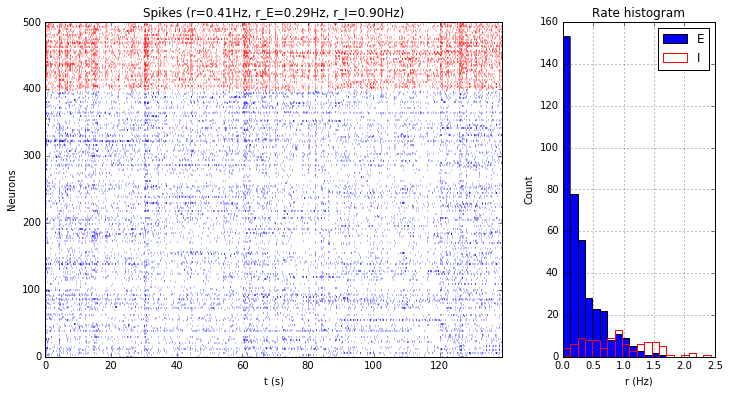

In [10]:
#plot spikes
ch_max = num_cells #max. number of channels to plot
nrn_colors = ['k', 'b', 'r'] #undefined/excitatory/inhibitory
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
for n in range(min(num_cells, ch_max)):
    ax[0].plot(spike_times[n], (n + 1)*np.ones_like(spike_times[n]), '|'+nrn_colors[nrn_type[n]], markersize=1)
    #ax[0].plot([spike_times[n], spike_times[n]], [(0.5+n)*np.ones_like(spike_times[n]), (1.5+n)*np.ones_like(spike_times[n])], nrn_colors[nrn_type[n]])
ax[0].set_xlim((0, signal_length))
#ax[0].set_xlim((0, 10))
ax[0].set_ylim((0.5, min(num_cells, ch_max)+0.5))
ax[0].set_xlabel('t (s)')
ax[0].set_ylabel('Neurons')
ax[0].set_title('Spikes (r=%.2fHz, r_E=%.2fHz, r_I=%.2fHz)'%(mean_rate, mean_rate_E, mean_rate_I))
ax[1].hist(np.array(firing_rates)[idx_E], 20, range=(0, max(firing_rates)), color=nrn_colors[1], label='E')
ax[1].hist(np.array(firing_rates)[idx_I], 20, range=(0, max(firing_rates)), edgecolor=nrn_colors[2], facecolor='none', label='I')
ax[1].set_xlabel('r (Hz)')
ax[1].set_ylabel('Count')
ax[1].set_title('Rate histogram')
ax[1].grid(True)
ax[1].legend()
#ax[1].hist(np.array(ISI_list), 20)
#ax[1].set_xlabel('ISI (s)')
#ax[1].set_title('ISI histogram')
#ax[1].grid(True)
fig.savefig(res_folder + 'spikes.png', dpi=600)